In [1]:
#import packages
import pandas as pd
import geopandas as gpd
import requests
from shapely.geometry import shape, Point
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import urllib.request, json
import requests
import urllib.parse
import datetime
import os
import dask.dataframe as dd
import calendar
from datetime import datetime, timedelta

from geopandas.tools import sjoin

import warnings
warnings.filterwarnings('ignore')

/Users/lizjohnson/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#import nta shapefile
nta_url = 'https://data.cityofnewyork.us/resource/q2z5-ai38.json'

query = (nta_url+'?'
        "$select=*"
        "&$limit=10000")
query = query.replace(" ", "%20")
response = urllib.request.urlopen(query)
data = json.loads(response.read())


for d in data:
    d['geometry'] = shape(d['the_geom'])

#store in a geodataframe
nta_nyc = gpd.GeoDataFrame(data, geometry = 'geometry', crs = 'EPSG: 4326')
nta_nyc = nta_nyc.drop(columns = ['the_geom'])
nta_nyc.head()

,boro_code,boro_name,county_fips,ntacode,ntaname,shape_leng,shape_area,geometry
0,4,Queens,081,QN08,St. Albans,45401.316803,77412747.847,"MULTIPOLYGON (((-73.75205 40.70523, -73.75174 ..."
1,2,Bronx,005,BX28,Van Cortlandt Village,21945.719299,25666124.5948,"MULTIPOLYGON (((-73.88705 40.88435, -73.88705 ..."
2,4,Queens,081,QN55,South Ozone Park,36708.1693055,82461393.7368,"MULTIPOLYGON (((-73.80577 40.68293, -73.80552 ..."
3,3,Brooklyn,047,BK40,Windsor Terrace,19033.6720656,14041667.99,"MULTIPOLYGON (((-73.98017 40.66115, -73.98021 ..."
4,3,Brooklyn,047,BK50,Canarsie,43703.6096661,82089678.6389,"MULTIPOLYGON (((-73.88834 40.64671, -73.88835 ..."


In [4]:
#import streeteast data
streeteasy = pd.read_csv('../Data/medianSalesPrice_All.csv')
streeteasy.head()

,areaName,Borough,areaType,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,...,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12,2023-01,2023-02,2023-03
0,All Downtown,Manhattan,submarket,900000.0,849500.0,990000.0,992793.0,916962.5,800000.0,1125000.0,...,1625000.0,1399999.0,1400178.0,1400000.0,1345000.0,1450000.0,1350000.0,1399420.0,1295000.0,1550000.0
1,All Midtown,Manhattan,submarket,685000.0,637500.0,600000.0,687500.0,750000.0,598000.0,748000.0,...,875000.0,875000.0,875000.0,780000.0,795000.0,1045000.0,887500.0,800000.0,800000.0,875000.0
2,All Upper East Side,Manhattan,submarket,1004500.0,831421.0,995000.0,875000.0,1200000.0,827391.0,993750.0,...,1150000.0,1242500.0,1132155.0,1192500.0,997000.0,1114900.0,1237500.0,1207500.0,1400000.0,1145000.0
3,All Upper Manhattan,Manhattan,submarket,366022.0,393496.0,350139.5,334620.0,338750.0,415740.0,433000.0,...,725000.0,640000.0,685000.0,680000.0,592000.0,495930.0,457500.0,547500.0,659000.0,730000.0
4,All Upper West Side,Manhattan,submarket,860421.0,875000.0,747250.0,803603.5,900000.0,769750.0,985000.0,...,1287500.0,1270000.0,1265000.0,1317500.0,1120000.0,975000.0,1047500.0,1072441.5,1100000.0,967500.0


In [5]:
streeteasy['areaType'].unique()

array(['submarket', 'neighborhood', 'borough', 'city'], dtype=object)

In [6]:
neighborhoods = streeteasy[streeteasy['areaType'] == 'neighborhood']['areaName'].unique().tolist()

In [7]:
neighborhoods

['Astoria',
 'Auburndale',
 'Bath Beach',
 'Battery Park City',
 'Bay Ridge',
 'Baychester',
 'Bayside',
 'Bedford Park',
 'Bedford-Stuyvesant',
 'Bellerose',
 'Belmont',
 'Bensonhurst',
 'Bergen Beach',
 'Boerum Hill',
 'Borough Park',
 'Briarwood',
 'Brighton Beach',
 'Bronxwood',
 'Brooklyn Heights',
 'Brookville',
 'Brownsville',
 'Bushwick',
 'Cambria Heights',
 'Canarsie',
 'Carroll Gardens',
 'Castle Hill',
 'Central Harlem',
 'Central Park South',
 'Chelsea',
 'Chinatown',
 'City Island',
 'Civic Center',
 'Clearview',
 'Clinton Hill',
 'Co-op City',
 'Cobble Hill',
 'College Point',
 'Columbia St Waterfront District',
 'Concourse',
 'Coney Island',
 'Corona',
 'Country Club',
 'Crotona Park East',
 'Crown Heights',
 'DUMBO',
 'Ditmas Park',
 'Douglaston',
 'Downtown Brooklyn',
 'Dyker Heights',
 'East Elmhurst',
 'East Flatbush',
 'East Harlem',
 'East New York',
 'East Tremont',
 'East Village',
 'Eastchester',
 'Edenwald',
 'Elmhurst',
 'Financial District',
 'Flatbush',
 'F

In [8]:
len(neighborhoods)

177

In [11]:
ntas = nta_nyc['ntaname'].tolist()
len(ntas)

195

In [45]:
ntas.sort()
ntas

['Airport',
 'Allerton-Pelham Gardens',
 "Annadale-Huguenot-Prince's Bay-Eltingville",
 'Arden Heights',
 'Astoria',
 'Auburndale',
 'Baisley Park',
 'Bath Beach',
 'Battery Park City-Lower Manhattan',
 'Bay Ridge',
 'Bayside-Bayside Hills',
 'Bedford',
 'Bedford Park-Fordham North',
 'Bellerose',
 'Belmont',
 'Bensonhurst East',
 'Bensonhurst West',
 'Borough Park',
 'Breezy Point-Belle Harbor-Rockaway Park-Broad Channel',
 'Briarwood-Jamaica Hills',
 'Brighton Beach',
 'Bronxdale',
 'Brooklyn Heights-Cobble Hill',
 'Brownsville',
 'Bushwick North',
 'Bushwick South',
 'Cambria Heights',
 'Canarsie',
 'Carroll Gardens-Columbia Street-Red Hook',
 'Central Harlem North-Polo Grounds',
 'Central Harlem South',
 'Charleston-Richmond Valley-Tottenville',
 'Chinatown',
 'Claremont-Bathgate',
 'Clinton',
 'Clinton Hill',
 'Co-op City',
 'College Point',
 'Corona',
 'Crotona Park East',
 'Crown Heights North',
 'Crown Heights South',
 'Cypress Hills-City Line',
 'DUMBO-Vinegar Hill-Downtown Br

In [17]:
matches = {}
for neighborhood in neighborhoods:
    match = process.extractOne(neighborhood,ntas, score_cutoff=80)
    matches[neighborhood] = match[0] if match else None

In [44]:
print(matches)

{'Astoria': 'Astoria', 'Auburndale': 'Auburndale', 'Bath Beach': 'Bath Beach', 'Battery Park City': 'Battery Park City-Lower Manhattan', 'Bay Ridge': 'Bay Ridge', 'Baychester': 'Eastchester-Edenwald-Baychester', 'Bayside': 'Bayside-Bayside Hills', 'Bedford Park': 'Bedford', 'Bedford-Stuyvesant': 'Bedford', 'Bellerose': 'Bellerose', 'Belmont': 'Belmont', 'Bensonhurst': 'Bensonhurst West', 'Bergen Beach': 'Georgetown-Marine Park-Bergen Beach-Mill Basin', 'Boerum Hill': 'DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill', 'Borough Park': 'Borough Park', 'Briarwood': 'Briarwood-Jamaica Hills', 'Brighton Beach': 'Brighton Beach', 'Bronxwood': None, 'Brooklyn Heights': 'Brooklyn Heights-Cobble Hill', 'Brookville': 'Springfield Gardens South-Brookville', 'Brownsville': 'Brownsville', 'Bushwick': 'Bushwick North', 'Cambria Heights': 'Cambria Heights', 'Canarsie': 'Canarsie', 'Carroll Gardens': 'Carroll Gardens-Columbia Street-Red Hook', 'Castle Hill': 'Soundview-Castle Hill-Clason Point-Harding

In [49]:
nta_nyc[nta_nyc['ntaname'].isin(['Battery Park City-Lower Manhattan','Bedford','Central Harlem South','Glen Oaks-Floral Park-New Hyde Park','Brooklyn Heights-Cobble Hill',
                               'St. Albans','East Concourse-Concourse Village','Pelham Bay-Country Club-City Island','Douglas Manor-Douglaston-Little Neck',
                               'Bedford Park-Fordham North','Pomonok-Flushing Heights-Hillcrest','Marble Hill-Inwood','University Heights-Morris Heights',
                               'Van Nest-Morris Park-Westchester Square','Pelham Bay-Country Club-City Island','Allerton-Pelham Gardens',
                               'Pomonok-Flushing Heights-Hillcrest','East Concourse-Concourse Village','East Tremont'])]

,boro_code,boro_name,county_fips,ntacode,ntaname,shape_leng,shape_area,geometry
0,4,Queens,081,QN08,St. Albans,45401.316803,77412747.847,"MULTIPOLYGON (((-73.75205 40.70523, -73.75174 ..."
9,4,Queens,081,QN38,Pomonok-Flushing Heights-Hillcrest,30731.419772,38835920.1944,"MULTIPOLYGON (((-73.79640 40.73828, -73.79639 ..."
18,3,Brooklyn,047,BK75,Bedford,29992.9240956,32629788.7441,"MULTIPOLYGON (((-73.94193 40.70073, -73.94372 ..."
20,4,Queens,081,QN44,Glen Oaks-Floral Park-New Hyde Park,33597.0068119,45658768.9248,"MULTIPOLYGON (((-73.71050 40.72723, -73.71050 ..."
27,2,Bronx,005,BX10,Pelham Bay-Country Club-City Island,138109.393004,40214908.5498,"MULTIPOLYGON (((-73.78833 40.83467, -73.78931 ..."
43,3,Brooklyn,047,BK09,Brooklyn Heights-Cobble Hill,14264.5743374,9985082.73229,"MULTIPOLYGON (((-73.99236 40.68969, -73.99436 ..."
61,2,Bronx,005,BX31,Allerton-Pelham Gardens,25471.000135,31684835.4395,"MULTIPOLYGON (((-73.85364 40.87330, -73.85358 ..."
67,2,Bronx,005,BX05,Bedford Park-Fordham North,22565.4821727,14998883.8321,"MULTIPOLYGON (((-73.88363 40.86726, -73.88443 ..."
116,1,Manhattan,061,MN11,Central Harlem South,16624.4627089,14441227.8101,"MULTIPOLYGON (((-73.94177 40.80709, -73.94226 ..."
142,2,Bronx,005,BX17,East Tremont,29651.351481,19255261.1405,"MULTIPOLYGON (((-73.88312 40.84822, -73.88284 ..."


In [165]:
neigh_nta_dict = {'Astoria': ['Astoria','Old Astoria','Steinway'], 'Auburndale': 'Auburndale', 'Bath Beach': 'Bath Beach',
                  'Battery Park City': 'Battery Park City-Lower Manhattan', 'Bay Ridge': 'Bay Ridge',
                  'Baychester': 'Eastchester-Edenwald-Baychester', 'Bayside': 'Bayside-Bayside Hills',
                  'Bedford Park': 'Bedford Park-Fordham North', 'Bedford-Stuyvesant': ['Bedford','Stuyvesant Heights'],
                  'Bellerose': 'Bellerose', 'Belmont': 'Belmont', 'Bensonhurst': ['Bensonhurst East','Bensonhurst West'],
                  'Bergen Beach': 'Georgetown-Marine Park-Bergen Beach-Mill Basin',
                  'Boerum Hill': 'DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill', 'Borough Park': 'Borough Park',
                  'Briarwood': 'Briarwood-Jamaica Hills', 'Brighton Beach': ['Brighton Beach','West Brighton'],
                  'Bronxwood': 'Bronxdale', 'Brooklyn Heights': 'Brooklyn Heights-Cobble Hill',
                  'Brookville': 'Springfield Gardens South-Brookville', 'Brownsville': 'Brownsville', 
                  'Bushwick': ['Bushwick North','Bushwick South'], 'Cambria Heights': 'Cambria Heights',
                  'Canarsie': 'Canarsie', 'Carroll Gardens': 'Carroll Gardens-Columbia Street-Red Hook',
                  'Castle Hill': 'Soundview-Castle Hill-Clason Point-Harding Park',
                  'Central Harlem': ['Central Harlem North-Polo Grounds','Central Harlem South'],
                  'Central Park South': 'Midtown-Midtown South',
                  'Chelsea': 'Hudson Yards-Chelsea-Flatiron-Union Square', 'Chinatown': 'Chinatown',
                  'City Island': 'Pelham Bay-Country Club-City Island', 'Civic Center': 'SoHo-TriBeCa-Civic Center-Little Italy',
                  'Clearview': 'Ft. Totten-Bay Terrace-Clearview', 'Clinton Hill': 'Clinton Hill', 'Co-op City': 'Co-op City',
                  'Cobble Hill': 'Brooklyn Heights-Cobble Hill', 'College Point': 'College Point',
                  'Columbia St Waterfront District':'Carroll Gardens-Columbia Street-Red Hook', 'Concourse': ['West Concourse','East Concourse-Concourse Village'],
                  'Coney Island': 'Seagate-Coney Island', 'Corona': 'Corona', 'Country Club': 'Pelham Bay-Country Club-City Island',
                  'Crotona Park East': 'Crotona Park East', 'Crown Heights': ['Ocean Hill','Crown Heights North','Crown Heights South'],
                  'DUMBO': 'DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill', 
                  'Ditmas Park': 'Flatbush', 'Douglaston': 'Douglas Manor-Douglaston-Little Neck', 
                  'Downtown Brooklyn': 'DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill', 'Dyker Heights': 'Dyker Heights', 
                  'East Elmhurst': 'East Elmhurst', 'East Flatbush': 'East Flatbush-Farragut', 'East Harlem': ['East Harlem North','East Harlem South'], 
                  'East New York': ['East New York','East New York (Pennsylvania Ave)','Cypress Hills-City Line','Starrett City'], 'East Tremont': 'East Tremont', 'East Village': 'East Village',
                  'Eastchester': 'Eastchester-Edenwald-Baychester', 'Edenwald': 'Eastchester-Edenwald-Baychester', 
                  'Elmhurst': ['Elmhurst','Elmhurst-Maspeth'], 'Financial District': 'Battery Park City-Lower Manhattan', 'Flatbush': ['Flatbush','Erasmus'],
                  'Flatiron': 'Hudson Yards-Chelsea-Flatiron-Union Square', 'Flatlands': 'Flatlands',
                  'Floral Park': 'Glen Oaks-Floral Park-New Hyde Park', 'Flushing': ['Flushing','','Murray Hill','East Flushing','Queensboro Hill'],
                  'Fordham': 'Bedford Park-Fordham North', 'Forest Hills': 'Forest Hills', 'Fort Greene': 'Fort Greene',
                  'Fresh Meadows': 'Fresh Meadows-Utopia', 'Gerritsen Beach': 'Sheepshead Bay-Gerritsen Beach-Manhattan Beach',
                  'Glen Oaks': 'Glen Oaks-Floral Park-New Hyde Park', 'Glendale': 'Glendale', 'Gowanus': 'Park Slope-Gowanus',
                  'Gramercy Park': 'Gramercy', 'Gravesend': 'Gravesend', 'Greenpoint': 'Greenpoint',
                  'Greenwich Village': 'West Village', 'Greenwood': 'Sunset Park West', 'Hamilton Heights': 'Hamilton Heights',
                  'Highbridge': 'Highbridge', 'Hillcrest': 'Pomonok-Flushing Heights-Hillcrest', 'Hollis': 'Hollis', 
                  'Howard Beach': 'Lindenwood-Howard Beach', 'Hunts Point': 'Hunts Point', 'Inwood': 'Marble Hill-Inwood',
                  'Jackson Heights': 'Jackson Heights', 'Jamaica': 'Jamaica', 'Jamaica Estates': 'Jamaica Estates-Holliswood', 'Jamaica Hills': 'Briarwood-Jamaica Hills',
                  'Kensington': 'Kensington-Ocean Parkway', 'Kew Gardens': 'Kew Gardens', 'Kew Gardens Hills': 'Kew Gardens Hills', 
                  'Kingsbridge': 'Van Cortlandt Village', 'Laconia': 'Allerton-Pelham Gardens', 'Laurelton': 'Laurelton',
                  'Little Italy': 'SoHo-TriBeCa-Civic Center-Little Italy', 'Little Neck': 'Douglas Manor-Douglaston-Little Neck',
                  'Long Island City': 'Queensbridge-Ravenswood-Long Island City', 'Longwood': 'Longwood',
                  'Lower East Side': 'Lower East Side', 'Manhattan Beach': 'Sheepshead Bay-Gerritsen Beach-Manhattan Beach',
                  'Marble Hill': 'Marble Hill-Inwood', 'Marine Park': 'Georgetown-Marine Park-Bergen Beach-Mill Basin',
                  'Maspeth': 'Maspeth', 'Melrose': ['Morrisania-Melrose','Melrose South-Mott Haven North'], 'Middle Village': 'Middle Village', 
                  'Midtown': 'Midtown-Midtown South', 'Midtown East': ['Turtle Bay-East Midtown','Murray Hill-Kips Bay'], 
                  'Midtown South': 'Midtown-Midtown South', 'Midtown West': 'Clinton', 'Midwood': 'Midwood',
                  'Mill Basin': 'Georgetown-Marine Park-Bergen Beach-Mill Basin', 'Morningside Heights': 'Morningside Heights',
                  'Morris Heights': 'University Heights-Morris Heights', 'Morris Park': 'Van Nest-Morris Park-Westchester Square',
                  'Morrisania': 'Morrisania-Melrose', 'Mott Haven': 'Melrose South-Mott Haven North',
                  'New Hyde Park': 'Glen Oaks-Floral Park-New Hyde Park', 'Nolita': 'SoHo-TriBeCa-Civic Center-Little Italy', 'North Corona': 'North Corona',
                  'Norwood': 'Norwood', 'Oakland Gardens': 'Oakland Gardens', 'Ocean Parkway': 'Ocean Parkway South',
                  'Old Mill Basin': 'Georgetown-Marine Park-Bergen Beach-Mill Basin', 'Ozone Park': 'Ozone Park', 'Park Slope': 'Park Slope-Gowanus',
                  'Parkchester': 'Parkchester', 'Pelham Bay': 'Pelham Bay-Country Club-City Island',
                  'Pelham Gardens': 'Allerton-Pelham Gardens', 'Pelham Parkway': 'Pelham Parkway', 'Pomonok': 'Pomonok-Flushing Heights-Hillcrest',
                  'Port Morris': 'Mott Haven-Port Morris', 'Prospect Heights': 'Prospect Heights',
                  'Prospect Lefferts Gardens': 'Prospect Lefferts Gardens-Wingate', 
                  'Prospect Park South': 'Flatbush', 'Queens Village': 'Queens Village',
                  'Red Hook': 'Carroll Gardens-Columbia Street-Red Hook', 'Rego Park': 'Rego Park', 'Richmond Hill': 'Richmond Hill',
                  'Ridgewood': 'Ridgewood', 'Riverdale': ['Spuyten Duyvil-Kingsbridge','North Riverdale-Fieldston-Riverdale'],
                  'Rockaway All': ['Far Rockaway-Bayswater','Hammels-Arverne-Edgemere','Breezy Point-Belle Harbor-Rockaway Park-Broad Channel'],
                  'Roosevelt Island': 'Lenox Hill-Roosevelt Island', 'Rosedale': 'Rosedale', 'Schuylerville': 'Schuylerville-Throgs Neck-Edgewater Park',
                  'Seagate': 'Seagate-Coney Island', 'Sheepshead Bay': ['Sheepshead Bay-Gerritsen Beach-Manhattan Beach','Homecrest','Madison'], 'Soho': 'SoHo-TriBeCa-Civic Center-Little Italy',
                  'Soundview': ['Soundview-Bruckner','West Farms-Bronx River'], 'South Jamaica': ['South Jamaica','Baisley Park'], 'South Ozone Park': 'South Ozone Park',
                  'South Richmond Hill': 'Richmond Hill', 'Springfield Gardens': ['Springfield Gardens North','Springfield Gardens South-Brookville'], 'St. Albans': 'St. Albans',
                  'Stuyvesant Town/PCV': 'Stuyvesant Town-Cooper Village', 'Sunnyside': 'Hunters Point-Sunnyside-West Maspeth', 'Sunset Park': 'Sunset Park East', 
                  'Throgs Neck': 'Schuylerville-Throgs Neck-Edgewater Park', 'Tremont': ['Fordham South','Mount Hope'], 'Tribeca': 'SoHo-TriBeCa-Civic Center-Little Italy',
                  'University Heights': ['University Heights-Morris Heights','Kingsbridge Heights'], 'Upper East Side':['Upper East Side-Carnegie Hill','Yorkville'],'Upper West Side': ['Upper West Side','Lincoln Square'],
                  'Utopia': 'Fresh Meadows-Utopia', 'Van Nest': 'Van Nest-Morris Park-Westchester Square',
                  'Wakefield': 'Woodlawn-Wakefield', 'Washington Heights': ['Washington Heights North','Washington Heights South'],
                  'West Harlem': 'Manhattanville', 'West Village': 'West Village', 'Westchester Village': 'Westchester-Unionport',
                  'Whitestone': 'Whitestone', 'Williamsbridge': 'Williamsbridge-Olinville', 'Williamsburg': ['North Side-South Side','Williamsburg','East Williamsburg'],
                  'Windsor Terrace': 'Windsor Terrace', 'Woodhaven': 'Woodhaven', 'Woodlawn': 'Woodlawn-Wakefield',
                  'Woodside': 'Woodside', 'Woodstock': 'Melrose South-Mott Haven North'}

In [166]:
for i, row in nta_nyc.iterrows():
    for key, value in neigh_nta_dict.items():
        if row['ntaname'] == value:
            nta_nyc.loc[i, 'streeteasy_neighborhood'] = key

In [167]:
for nta in nta_nyc['ntaname'].unique():
    if nta in [val_item for val in neigh_nta_dict.values() for val_item in val]:
        key = [k for k, v in neigh_nta_dict.items() if nta in [val_item for val_item in v]][0]
        nta_nyc.loc[nta_nyc['ntaname'] == nta, 'streeteasy_neighborhood'] = key

In [168]:
nta_nyc[(nta_nyc['streeteasy_neighborhood'].isna()) & (~nta_nyc['ntaname'].str.contains('park-cemetery-etc')) &(nta_nyc['boro_name']!= 'Staten Island')]

,boro_code,boro_name,county_fips,ntacode,ntaname,shape_leng,shape_area,geometry,streeteasy_neighborhood
13,2,Bronx,005,BX98,Rikers Island,18897.4874063,18163734.8416,"MULTIPOLYGON (((-73.87287 40.78598, -73.87288 ...",NaN
83,3,Brooklyn,047,BK96,Rugby-Remsen Village,30932.4265831,32705427.4422,"MULTIPOLYGON (((-73.90856 40.65210, -73.90945 ...",NaN
108,2,Bronx,005,BX01,Claremont-Bathgate,30053.1309484,16451870.7088,"MULTIPOLYGON (((-73.89039 40.85469, -73.89069 ...",NaN
121,4,Queens,081,QN98,Airport,136426.696878,228219796.793,"MULTIPOLYGON (((-73.74712 40.63716, -73.74707 ...",NaN


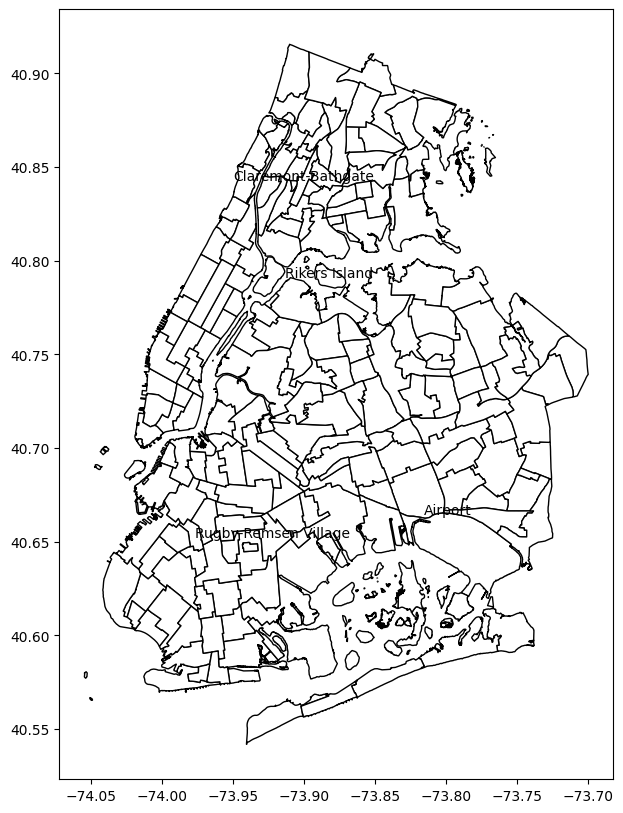

In [169]:
# Plot the borough
ax = nta_nyc[nta_nyc['boro_name']!= 'Staten Island'].plot(figsize=(10,10), color='white', edgecolor='black')

# Add labels for each ntacode
for i, row in nta_nyc[(nta_nyc['streeteasy_neighborhood'].isna()) & (~nta_nyc['ntaname'].str.contains('park-cemetery-etc')) &(nta_nyc['boro_name']!= 'Staten Island')].iterrows():
    # Get the centroid of the polygon
    centroid = row['geometry'].centroid

    # Add the ntaname as a label
    ax.annotate(text=row['ntaname'], xy=(centroid.x, centroid.y), color='black', ha='center',wrap = True)

# Show the plot
plt.show()

In [170]:
nta_nyc[nta_nyc['boro_name']== 'Staten Island']

,boro_code,boro_name,county_fips,ntacode,ntaname,shape_leng,shape_area,geometry,streeteasy_neighborhood
24,5,Staten Island,085,SI11,Charleston-Richmond Valley-Tottenville,84983.5542062,145534202.094,"MULTIPOLYGON (((-74.20700 40.55757, -74.20880 ...",NaN
26,5,Staten Island,085,SI08,Grymes Hill-Clifton-Fox Hills,37119.8872701,37752289.1507,"MULTIPOLYGON (((-74.08155 40.60629, -74.08281 ...",NaN
34,5,Staten Island,085,SI37,Stapleton-Rosebank,55199.7570248,46433358.0842,"MULTIPOLYGON (((-74.07258 40.63794, -74.07257 ...",NaN
45,5,Staten Island,085,SI12,Mariner's Harbor-Arlington-Port Ivory-Granitev...,71207.5257644,89462868.5032,"MULTIPOLYGON (((-74.15946 40.64145, -74.15975 ...",NaN
46,5,Staten Island,085,SI28,Port Richmond,39056.4172979,36417486.9792,"MULTIPOLYGON (((-74.12613 40.64126, -74.12600 ...",NaN
53,5,Staten Island,085,SI14,Grasmere-Arrochar-Ft. Wadsworth,39936.903974,40915287.4316,"MULTIPOLYGON (((-74.08155 40.60629, -74.08015 ...",NaN
92,5,Staten Island,085,SI45,New Dorp-Midland Beach,34369.8892724,55448202.1327,"MULTIPOLYGON (((-74.08469 40.57148, -74.08595 ...",NaN
93,5,Staten Island,085,SI36,Old Town-Dongan Hills-South Beach,41972.4468555,67011977.4534,"MULTIPOLYGON (((-74.06503 40.58899, -74.06503 ...",Old Mill Basin
114,5,Staten Island,085,SI99,park-cemetery-etc-Staten Island,41433.8239557,23386261.5844,"MULTIPOLYGON (((-74.11338 40.54807, -74.11341 ...",NaN
127,5,Staten Island,085,SI24,Todt Hill-Emerson Hill-Heartland Village-Light...,75942.3867008,184889367.626,"MULTIPOLYGON (((-74.09777 40.61062, -74.09730 ...",NaN
